# Experiment 3: Smart Ensemble Optimization with Market-Aware Weight

## Step 1: Asset Pre-Selection

> **Goal** - A diverse-, low-correlated and economically meaningful asset portfolio.

We start with a universe of 100 assets, primarily with tickers available at Yahoo finance and carefully selected from multiple asset categories including U.S. Equities, International Equities, Emerging Market Equities, REITs, Bonds, Commodities, ETFs, and Cryptocurrencies.

We obtain the daily prices over the past 5 years (to cover both systemic and idiosyncratic risks, while balancing for estimation error and representativeness), and build monthly prices from the daily closing prices via aggregation because not all assets have daily prices (to reduce the noise), and this results in at most 60 data points.

We then apply quality filters on the monthly returns calculated from the monthly prices. The quality filters in this case include history, liquidity, and market capitalization, where applicable. We then estimate the denoised correlation and covariance matrices from the monthly returns, measure the multiple dependencies, and reduce redundancy using clustering and selection algorithms.

Finally, we check the robustness using factor-adjustment, conditional correlation analysis, rolling stability tests, and multiple testing control. The process results in a total of 30 stocks from diverse markets and industries that we use in the portfolio optimization process with Markowitz.

In [1]:
import os
import random
import datetime as dt
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf

import networkx as nx

warnings.filterwarnings('ignore')

We start by carefully selecting 100 assets with tickers available on Yahoo finance to represent categories in categories including U.S. Equities, International Equities, Emerging Market Equities, REITs, Bonds, Commodities, ETFs, and Cryptocurrencies.

Here is the summary of the asset categories selected for the universe of 100 assets from which we statistically selected 30 assets for training the Markowitz model:

Here is the provided data presented in a clean, well-formatted markdown table.

### Investment Allocation Summary

| Asset Class | Frequency | Market / Region |
| :--- | :--- | :--- |
| **U.S. Equities** | 25 | United States |
| **International Equities** | 14 | Europe, Japan, Canada, Australia |
| **Emerging Market Equities** | 11 | India, China, Brazil, Africa |
| **REITs** | 10 | Primarily U.S. |
| **Bonds** | 8 | U.S. and Global |
| **Commodities** | 6 | Global |
| **ETFs** | 20 | U.S. and Global |
| **Cryptocurrencies** | 6 | Global |
| **Total** | **100** | |

In [2]:
us_large_cap = [
    "AAPL", "MSFT", "GOOG", "AMZN", "META", "NVDA", "TSLA", "BRK-B", "JPM", "V",
    "PG", "HD", "UNH", "MA", "PFE", "KO", "PEP", "DIS", "XOM", "BAC",
    "NFLX", "CSCO", "INTC", "WMT", "CVX", "ABBV", "NKE", "MRK", "MCD", "COST",
    "CRM", "AMD", "AVGO", "TMO", "LLY"
]

sector_etfs = [
    "SPY", "QQQ", "DIA", "IWM", "XLK", "XLF", "XLE", "XLV", "XLY", "XLP",
    "XLI", "XLRE", "XLC", "ARKK", "SMH", "SOXX", "IYT", "XAR", "XHB", "VNQ",
    "VTI", "VOO", "VT", "VEA", "IJR"
]

reits = [
    "AMT", "PLD", "CCI", "SPG", "O", "EQIX", "WELL", "PSA", "VTR", "DLR"
]

bonds = [
    "TLT", "IEF", "LQD", "HYG", "BND", "AGG", "SHY", "EMB", "TIP", "BIL"
]

commodities = [
    "GLD", "SLV", "USO", "DBA", "CPER", "URA", "UNG", "CORN", "WEAT", "PALL"
]

dividend_defensive = [
    "KO", "PEP", "JNJ", "PG", "DUK", "SO", "CL", "WMT", "COST", "TGT"
]

ticker_list = (
    us_large_cap +
    sector_etfs +
    reits +
    bonds +
    commodities +
    dividend_defensive
)

print("Total tickers:", len(ticker_list))


Total tickers: 100


In [3]:
# Configs
START_DATE = '2015-01-01'
END_DATE = dt.datetime.today().strftime('%Y-%m-%d')
MIN_MONTHS_HISTORY = 60
MIN_AVG_DAILY_VOLUME = 100_000
FINAL_K = 30
OUT_FOLDER = "asset_preselection_outputs"

Fetch Data

In [4]:
def fetch_daily_data(tickers, start, end):
    raw = yf.download(tickers, start=start, end=end, progress=True, group_by='ticker', auto_adjust=False)
    if isinstance(raw.columns, pd.MultiIndex):
        adj = pd.DataFrame({t: raw[(t, 'Adj Close')] if (t, 'Adj Close') in raw.columns else raw[(t, 'Close')] for t in tickers})
        vol = pd.DataFrame({t: raw[(t, 'Volume')] if (t, 'Volume') in raw.columns else np.nan for t in tickers})
    else:
        adj = raw['Adj Close'].to_frame() if 'Adj Close' in raw else raw['Close'].to_frame()
        adj.columns = tickers
        vol = raw['Volume'].to_frame()
        vol.columns = tickers
    adj = adj.dropna(axis=1, how='all')
    vol = vol.reindex(adj.index).fillna(method='ffill')
    return adj, vol
adj_daily, volume_daily = fetch_daily_data(ticker_list, START_DATE, END_DATE)
print("Downloaded price columns:", adj_daily.columns.tolist())

[*********************100%***********************]  95 of 95 completed

Downloaded price columns: ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'BRK-B', 'JPM', 'V', 'PG', 'HD', 'UNH', 'MA', 'PFE', 'KO', 'PEP', 'DIS', 'XOM', 'BAC', 'NFLX', 'CSCO', 'INTC', 'WMT', 'CVX', 'ABBV', 'NKE', 'MRK', 'MCD', 'COST', 'CRM', 'AMD', 'AVGO', 'TMO', 'LLY', 'SPY', 'QQQ', 'DIA', 'IWM', 'XLK', 'XLF', 'XLE', 'XLV', 'XLY', 'XLP', 'XLI', 'XLRE', 'XLC', 'ARKK', 'SMH', 'SOXX', 'IYT', 'XAR', 'XHB', 'VNQ', 'VTI', 'VOO', 'VT', 'VEA', 'IJR', 'AMT', 'PLD', 'CCI', 'SPG', 'O', 'EQIX', 'WELL', 'PSA', 'VTR', 'DLR', 'TLT', 'IEF', 'LQD', 'HYG', 'BND', 'AGG', 'SHY', 'EMB', 'TIP', 'BIL', 'GLD', 'SLV', 'USO', 'DBA', 'CPER', 'URA', 'UNG', 'CORN', 'WEAT', 'PALL', 'JNJ', 'DUK', 'SO', 'CL', 'TGT']


In [5]:
# Computing monthly last price (month-end) and computing monthly returns
adj_monthly = adj_daily.resample('M').last().ffill()

def avg_daily_volume_over_period(volume_df, window_days=252):
    return volume_df.rolling(window=window_days, min_periods=1).mean().iloc[-1]

avg_vol = avg_daily_volume_over_period(volume_daily, window_days=252)
avg_vol = avg_vol.fillna(0)
meta = pd.DataFrame({
    'ticker': adj_monthly.columns,
    'first_date': adj_monthly.notna().idxmax(),
    'last_date': adj_monthly.notna().idxmin(),  # not perfect but we store for reference
    'avg_daily_volume': avg_vol.reindex(adj_monthly.columns).fillna(0).values
}).set_index('ticker')
print(meta.head())

       first_date  last_date  avg_daily_volume
ticker                                        
AAPL   2015-01-31 2015-01-31      5.380889e+07
MSFT   2015-01-31 2015-01-31      2.170195e+07
GOOG   2015-01-31 2015-01-31      2.262016e+07
AMZN   2015-01-31 2015-01-31      4.282753e+07
META   2015-01-31 2015-01-31      1.401578e+07


In [6]:
# Chistory + liquidity filters
def history_filter(price_monthly_df, min_months=60):
    valid = price_monthly_df.notna().sum(axis=0) >= min_months
    return price_monthly_df.loc[:, valid]

# require at least MIN_MONTHS_HISTORY
adj_monthly_filtered = history_filter(adj_monthly, min_months=MIN_MONTHS_HISTORY)

# liquidity threshold
liquid_tickers = meta.loc[adj_monthly_filtered.columns]['avg_daily_volume'] >= MIN_AVG_DAILY_VOLUME
liquid_tickers = liquid_tickers[liquid_tickers].index.tolist()

# Final tickers after both filters
final_universe_tickers = [t for t in adj_monthly_filtered.columns if t in liquid_tickers]
adj_monthly_filtered = adj_monthly_filtered[final_universe_tickers]

print(f"Universe size after filters: {len(adj_monthly_filtered.columns)}")
print("Tickers:", list(adj_monthly_filtered.columns))

Universe size after filters: 94
Tickers: ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'BRK-B', 'JPM', 'V', 'PG', 'HD', 'UNH', 'MA', 'PFE', 'KO', 'PEP', 'DIS', 'XOM', 'BAC', 'NFLX', 'CSCO', 'INTC', 'WMT', 'CVX', 'ABBV', 'NKE', 'MRK', 'MCD', 'COST', 'CRM', 'AMD', 'AVGO', 'TMO', 'LLY', 'SPY', 'QQQ', 'DIA', 'IWM', 'XLK', 'XLF', 'XLE', 'XLV', 'XLY', 'XLP', 'XLI', 'XLRE', 'XLC', 'ARKK', 'SMH', 'SOXX', 'IYT', 'XAR', 'XHB', 'VNQ', 'VTI', 'VOO', 'VT', 'VEA', 'IJR', 'AMT', 'PLD', 'CCI', 'SPG', 'O', 'EQIX', 'WELL', 'PSA', 'VTR', 'DLR', 'TLT', 'IEF', 'LQD', 'HYG', 'BND', 'AGG', 'SHY', 'EMB', 'TIP', 'BIL', 'GLD', 'SLV', 'USO', 'DBA', 'CPER', 'URA', 'UNG', 'WEAT', 'PALL', 'JNJ', 'DUK', 'SO', 'CL', 'TGT']


In [7]:
# monthly log returns (T x N)
returns = np.log(adj_monthly_filtered).diff().dropna()
returns.head(3)

,AAPL,MSFT,GOOG,AMZN,META,NVDA,TSLA,BRK-B,JPM,V,...,CPER,URA,UNG,WEAT,PALL,JNJ,DUK,SO,CL,TGT
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-31,0.027599,0.073021,0.087165,0.044664,-0.118645,0.033049,-0.140021,0.058375,0.103605,0.031876,...,-0.044257,0.023043,-0.038276,0.084134,-0.019955,0.088137,0.031614,0.048266,0.039803,0.058179
2018-08-31,0.182673,0.061089,0.000764,0.124308,0.018088,0.137075,0.011737,0.053383,-0.003224,0.073104,...,-0.068195,-0.034766,0.048769,-0.039682,0.049214,0.022884,0.006735,-0.091734,-0.008994,0.088978
2018-09-30,-0.008338,0.017997,-0.020501,-0.004836,-0.066281,0.001211,-0.130439,0.025496,-0.015302,0.021551,...,0.050156,0.045340,0.036084,-0.065038,0.090338,0.025509,-0.015131,-0.004120,0.008098,0.008082


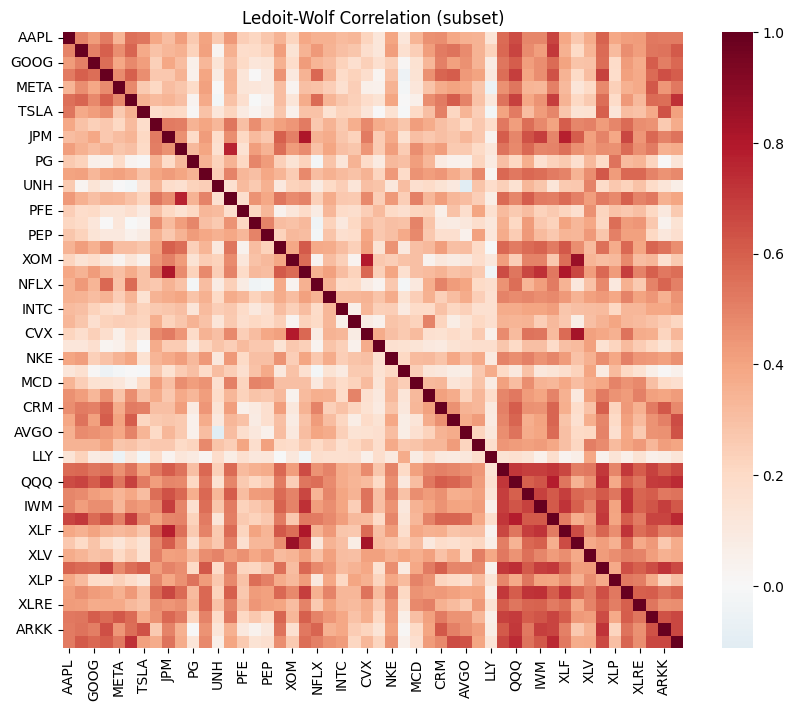

In [8]:
# Ledoit-Wolf covariance estimator (stable covariance)
lw = LedoitWolf().fit(returns.values)
cov_lw = lw.covariance_
# converting covariance matrix to DataFrame with tickers index/columns
cov_lw_df = pd.DataFrame(cov_lw, index=returns.columns, columns=returns.columns)

# computing correlation matrix from cov
std = np.sqrt(np.diag(cov_lw))
corr_lw = cov_lw / np.outer(std, std)
corr_lw_df = pd.DataFrame(corr_lw, index=returns.columns, columns=returns.columns)

# quick heatmap check
plt.figure(figsize=(10,8))
sns.heatmap(corr_lw_df.iloc[:50, :50], cmap='RdBu_r', center=0)
plt.title('Ledoit-Wolf Correlation (subset)')
plt.show()

In [9]:
corr_lw_df.head(3)

,AAPL,MSFT,GOOG,AMZN,META,NVDA,TSLA,BRK-B,JPM,V,...,CPER,URA,UNG,WEAT,PALL,JNJ,DUK,SO,CL,TGT
AAPL,1.000000,0.493381,0.425983,0.519822,0.339328,0.550250,0.537797,0.383809,0.309219,0.417465,...,0.175851,0.188968,0.105000,-0.001782,-0.019845,0.304942,0.119306,0.170967,0.212049,0.400377
MSFT,0.493381,1.000000,0.507736,0.595533,0.468188,0.586343,0.375394,0.292240,0.327561,0.361383,...,0.178285,0.333816,0.072115,-0.080202,0.032628,0.235666,0.130485,0.187347,0.268640,0.315609
GOOG,0.425983,0.507736,1.000000,0.558269,0.389395,0.482157,0.413888,0.236904,0.388766,0.306958,...,0.302209,0.387101,0.005285,0.013398,0.100706,0.105771,0.143474,0.193977,0.086794,0.268327


In [10]:
# Spearman correlation (rank-based)
corr_spearman = returns.corr(method='spearman')

# distance correlation- function + pairwise matrix
def distance_covariance(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    a = np.abs(x[:, None] - x[None, :])
    b = np.abs(y[:, None] - y[None, :])
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    return np.sqrt(np.sum(A * B) / (n * n))

def distance_corr(x, y):
    dxy = distance_covariance(x, y)
    dxx = distance_covariance(x, x)
    dyy = distance_covariance(y, y)
    if dxx * dyy == 0:
        return 0.0
    return dxy / np.sqrt(dxx * dyy)

# pairwise distance correlation matrix
def pairwise_distance_corr(returns_df):
    cols = returns_df.columns.tolist()
    n = len(cols)
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            dc = distance_corr(returns_df.iloc[:, i].values, returns_df.iloc[:, j].values)
            mat[i, j] = dc
            mat[j, i] = dc
    return pd.DataFrame(mat, index=cols, columns=cols)

dist_corr_df = pairwise_distance_corr(returns)
dist_corr_df.head()

,AAPL,MSFT,GOOG,AMZN,META,NVDA,TSLA,BRK-B,JPM,V,...,CPER,URA,UNG,WEAT,PALL,JNJ,DUK,SO,CL,TGT
AAPL,1.000000,0.596377,0.476802,0.550347,0.453106,0.567727,0.562836,0.421384,0.373834,0.474106,...,0.247227,0.244149,0.198493,0.128066,0.139033,0.375123,0.246001,0.265555,0.280755,0.414587
MSFT,0.596377,1.000000,0.584323,0.686899,0.561210,0.637025,0.407123,0.380288,0.414366,0.467895,...,0.265926,0.349866,0.200043,0.163646,0.160639,0.315197,0.202717,0.238722,0.337806,0.397144
GOOG,0.476802,0.584323,1.000000,0.588555,0.457776,0.498227,0.388310,0.325582,0.456236,0.382311,...,0.372919,0.451132,0.168907,0.174295,0.180110,0.233867,0.273808,0.263821,0.190910,0.342489
AMZN,0.550347,0.686899,0.588555,1.000000,0.553549,0.582611,0.478041,0.301859,0.340850,0.419432,...,0.215573,0.405010,0.205898,0.216482,0.160736,0.197450,0.146045,0.176874,0.212926,0.338921
META,0.453106,0.561210,0.457776,0.553549,1.000000,0.559783,0.302673,0.311093,0.465462,0.392090,...,0.321738,0.308592,0.170789,0.229856,0.145028,0.234069,0.203856,0.267565,0.271194,0.375585


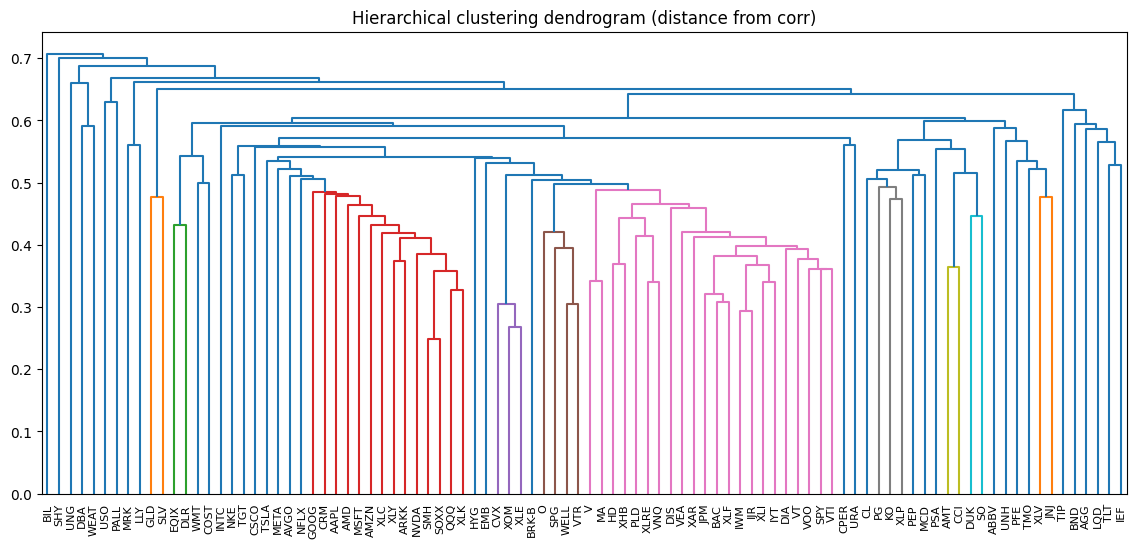

In [11]:
# hierarchical clustering on Pearson (Ledoit-Wolf) correlation
# converting correlations to distance metric for clustering
corr = corr_lw_df.copy()
corr = corr.clip(-0.9999, 0.9999)  # safety for sqrt
dist_matrix = np.sqrt((1 - corr) / 2)  # standard distance transform

# convert to condensed distance vector (required by linkage)
condensed = squareform(dist_matrix.values, checks=False)
Z = linkage(condensed, method='average')  # 'average' is robust (Ward also works on Euclidean)

# plot dendrogram for visual inspection (useful for smaller N)
plt.figure(figsize=(14, 6))
dendrogram(Z, labels=returns.columns.tolist(), leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical clustering dendrogram (distance from corr)')
plt.show()

### Category 1 Assets/Tickers

In [12]:
# greedy selection which iteratively picks the asset with minimal average corr to already selected set
def greedy_min_avg_corr(corr_df, k=30):
    names = corr_df.columns.tolist()
    selected = []
    avg_corr = corr_df.mean(axis=1)
    first = avg_corr.idxmin()
    selected.append(first)
    while len(selected) < k:
        candidates = [n for n in names if n not in selected]
        # computing average correlation to the selected set for each candidate
        scores = {c: corr_df.loc[c, selected].mean() for c in candidates}
        # picking candidate with minimal average correlation to selected
        next_one = min(scores, key=scores.get)
        selected.append(next_one)
    return selected

k = min(FINAL_K, len(returns.columns))
greedy_selected = greedy_min_avg_corr(corr_lw_df, k=k)
print("Greedy selection count:", len(greedy_selected))
print(greedy_selected)

Greedy selection count: 30
['WEAT', 'CRM', 'BIL', 'SHY', 'PALL', 'LLY', 'UNG', 'GLD', 'USO', 'IEF', 'PFE', 'AGG', 'DBA', 'CL', 'TSLA', 'BND', 'MRK', 'ABBV', 'NFLX', 'TIP', 'XOM', 'DLR', 'TLT', 'PG', 'AVGO', 'UNH', 'META', 'WMT', 'URA', 'SO']


### Category 2 Assets/Tickers

In [13]:
# generating cluster labels and pick representative(s)
n_clusters = min(FINAL_K, max(2, len(returns.columns)//2))
clusters = fcluster(Z, t=n_clusters, criterion='maxclust')
cluster_df = pd.DataFrame({'ticker': returns.columns, 'cluster': clusters}).set_index('ticker')

# helper to pick representative per cluster: lowest mean intra-cluster correlation, tiebreak by liquidity
def pick_cluster_representatives(corr_df, meta_df, per_cluster=1):
    reps = []
    for c in sorted(cluster_df['cluster'].unique()):
        members = cluster_df[cluster_df['cluster'] == c].index.tolist()
        sub_corr = corr_df.loc[members, members]
        mean_intra = sub_corr.mean(axis=1)
        ranked = mean_intra.sort_values().index.tolist()  # low mean_intra = less correlated to own cluster
        # tiebreak by liquidity if meta available
        if per_cluster == 1:
            reps.append(ranked[0])
        else:
            picks = ranked[:min(per_cluster, len(ranked))]
            reps.extend(picks)
    return reps

cluster_reps = pick_cluster_representatives(corr_lw_df, meta, per_cluster=1)
print("Cluster reps count:", len(cluster_reps))
print(cluster_reps)

Cluster reps count: 30
['DBA', 'WEAT', 'UNG', 'USO', 'PALL', 'MRK', 'LLY', 'GLD', 'EQIX', 'WMT', 'TGT', 'TSLA', 'HYG', 'CSCO', 'CPER', 'URA', 'INTC', 'CL', 'SO', 'PSA', 'PFE', 'UNH', 'ABBV', 'IEF', 'LQD', 'AGG', 'BND', 'TIP', 'SHY', 'BIL']


### Correlation for the Union of Category 1 and 2 Assets

> The correlation of All Assets that are in Category 1, 2 or both

In [14]:
# Heatmap
selected_union = list(set(cluster_reps) | set(greedy_selected))
subset = corr_lw_df.loc[selected_union, selected_union].copy()
subset.head(3)

,CRM,IEF,WEAT,UNG,TSLA,LLY,XOM,DBA,PFE,PSA,...,ABBV,CL,TLT,TIP,PALL,META,DLR,LQD,SHY,PG
CRM,1.000000,0.137267,-0.194101,-0.057332,0.501587,0.099743,0.114112,0.022555,0.059436,0.209995,...,0.095524,0.144411,0.170195,0.193029,0.005309,0.368541,0.254118,0.278241,0.028873,0.090154
IEF,0.137267,1.000000,-0.047010,-0.080993,0.032680,0.055078,-0.115179,-0.061359,0.069401,0.204144,...,0.029033,0.092949,0.442051,0.217884,0.040674,0.085341,0.177596,0.299575,0.086902,0.052723
WEAT,-0.194101,-0.047010,1.000000,0.138364,0.008022,-0.001979,-0.043632,0.302504,0.117710,0.109498,...,-0.012494,-0.128460,-0.034431,-0.009338,0.016277,-0.155149,0.027853,-0.060596,-0.021055,-0.063768


In [15]:
corr = subset.copy()
np.fill_diagonal(corr.values, np.nan)
corr_unstacked = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).unstack()
corr_unstacked = corr_unstacked.dropna()
max_corr_pair = corr_unstacked.idxmax()
min_corr_pair = corr_unstacked.idxmin()
max_corr_value = corr_unstacked.max()
min_corr_value = corr_unstacked.min()
print(f"🔹 Highest correlation: {max_corr_value:.4f} between {max_corr_pair[0]} and {max_corr_pair[1]}")
print(f"🔹 Lowest  correlation: {min_corr_value:.4f} between {min_corr_pair[0]} and {min_corr_pair[1]}")

🔹 Highest correlation: 0.6284 between DLR and EQIX
🔹 Lowest  correlation: -0.2413 between TLT and USO


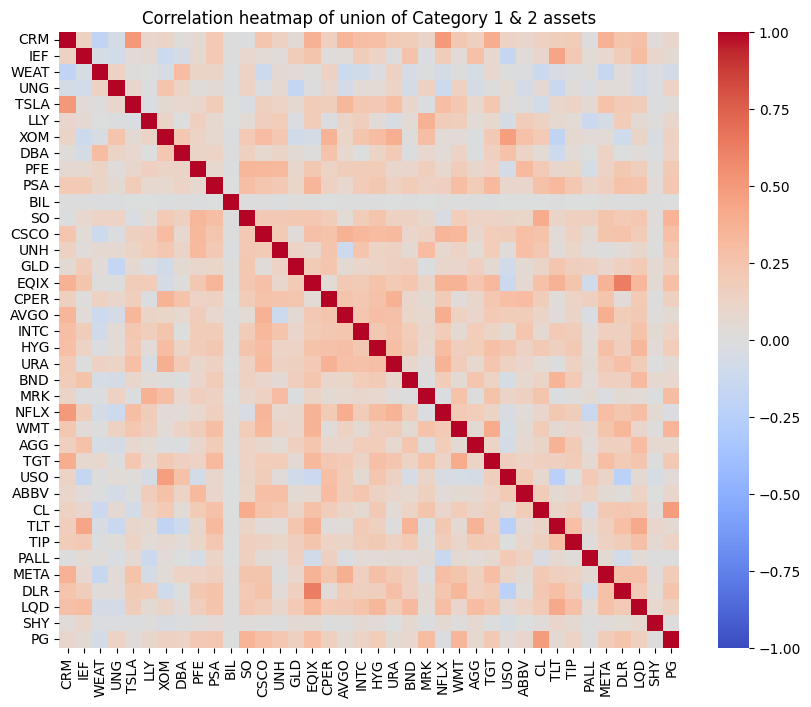

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(subset, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=False)
plt.title('Correlation heatmap of union of Category 1 & 2 assets')
plt.show()

### Conditional correlations

In [17]:
# PARAMETERS
market_ticker = 'SPY' # Benchmark Index
quantile_p = 0.10
n_boot = 2000
random_state = 42

# Sanity check inputs exist
for name in ['returns', 'corr_lw_df', 'greedy_selected', 'cluster_reps']:
    if name not in globals():
        raise NameError(f"Required variable '{name}' is not defined in the environment.")

# Ensure returns index is datetime-like (for resampling / selection safety)
returns.index = pd.to_datetime(returns.index)

# Helper utilities -
def upper_triangle_values_mean(corr_df):
    """Return mean of unique off-diagonal correlation values (upper triangle k=1)."""
    if corr_df.shape[0] < 2:
        return np.nan
    mat = corr_df.values
    iu = np.triu_indices_from(mat, k=1)
    vals = mat[iu]
    return float(np.nanmean(vals))

def bootstrap_avg_corr(returns_sub, months_idx, n_boot=1000, rng=None):
    """
    Bootstrap average off-diagonal correlation by resampling months (with replacement).
    returns_sub : DataFrame of returns (columns = tickers)
    months_idx    : sequence of timestamps (index values) to sample from
    """
    if rng is None:
        rng = np.random.default_rng(random_state)
    months = list(months_idx)
    if len(months) == 0:
        return np.array([]), (np.nan, np.nan)
    res = []
    pbar = None
    for _ in range(n_boot):
        samp_months = rng.choice(months, size=len(months), replace=True)
        try:
            R = returns_sub.loc[samp_months].dropna(axis=1, how='all')
        except Exception:
            # if indices don't align exactly, reindex
            R = returns_sub.reindex(samp_months).dropna(axis=1, how='all')
        if R.shape[1] < 2:
            res.append(np.nan)
            continue
        corr = R.corr()
        res.append(upper_triangle_values_mean(corr))
    arr = np.array(res, dtype=float)
    lower, upper = np.nanpercentile(arr, [2.5, 97.5])
    return arr, (lower, upper)

# Identifying crisis months (bottom decile of market returns)
if market_ticker not in returns.columns:
    raise KeyError(f"Market ticker '{market_ticker}' not found in returns.columns")

market_returns = returns[market_ticker].dropna()
threshold = market_returns.quantile(quantile_p)
crisis_idx = market_returns[market_returns <= threshold].index
T_c = len(crisis_idx)
print(f"Number of crisis months (bottom {int(quantile_p*100)}%): {T_c}")

# Preparing Category lists and check presence in returns/corr matrices
cat1 = [t for t in greedy_selected if t in returns.columns]      # Category 1 (greedy)
cat2 = [t for t in cluster_reps if t in returns.columns]         # Category 2 (clusters)

missing_cat1 = sorted(set(greedy_selected) - set(cat1))
missing_cat2 = sorted(set(cluster_reps) - set(cat2))
if missing_cat1:
    print(f"Warning: {len(missing_cat1)} greedy_selected tickers missing from returns and will be ignored: {missing_cat1}")
if missing_cat2:
    print(f"Warning: {len(missing_cat2)} cluster_reps tickers missing from returns and will be ignored: {missing_cat2}")

# --- Utility to compute summary for a given list of tickers ---
def compute_category_summary(tickers, label):
    out = {'label': label, 'n_assets': len(tickers)}
    if len(tickers) < 2:
        out.update({
            'avg_full_offdiag': np.nan,
            'avg_crisis_offdiag': np.nan,
            'delta_crisis_minus_full': np.nan,
            'full_ci_lower': np.nan, 'full_ci_upper': np.nan,
            'crisis_ci_lower': np.nan, 'crisis_ci_upper': np.nan
        })
        return out

    # Full-sample correlation (Ledoit-Wolf) -- use corr_lw_df if it contains tickers
    if not set(tickers).issubset(set(corr_lw_df.index)):
        # If corr_lw_df doesn't include some tickers, fallback to sample corr computed on full returns
        corr_full = returns[tickers].dropna(axis=1, how='all').corr()
    else:
        corr_full = corr_lw_df.loc[tickers, tickers]

    avg_full = upper_triangle_values_mean(corr_full)

    # Crisis correlation (sample on crisis months)
    R_crisis = returns.loc[crisis_idx, tickers].dropna(axis=1, how='all')
    if R_crisis.shape[1] < 2 or R_crisis.shape[0] == 0:
        avg_crisis = np.nan
    else:
        corr_crisis = R_crisis.corr()
        avg_crisis = upper_triangle_values_mean(corr_crisis)

    # Bootstrapped CIs (months-level bootstrap)
    # Full-sample bootstrap: resampling from full sample months
    full_arr, (full_lo, full_hi) = bootstrap_avg_corr(returns[tickers], returns.index, n_boot=n_boot)
    crisis_arr, (crisis_lo, crisis_hi) = bootstrap_avg_corr(returns[tickers], crisis_idx, n_boot=n_boot)

    out.update({
        'avg_full_offdiag': avg_full,
        'avg_crisis_offdiag': avg_crisis,
        'delta_crisis_minus_full': (avg_crisis - avg_full) if (avg_crisis is not None and avg_full is not None) else np.nan,
        'full_boot_mean': np.nanmean(full_arr),
        'full_ci_lower': full_lo, 'full_ci_upper': full_hi,
        'crisis_boot_mean': np.nanmean(crisis_arr),
        'crisis_ci_lower': crisis_lo, 'crisis_ci_upper': crisis_hi
    })
    return out

# summaries
summary_cat1 = compute_category_summary(cat1, 'Category1_greedy')
summary_cat2 = compute_category_summary(cat2, 'Category2_cluster')

summary_df = pd.DataFrame([summary_cat1, summary_cat2]).set_index('label')

# Intersection
intersection = sorted(set(cat1).intersection(set(cat2)))
summary_df['n_intersection'] = len(intersection)

#summary
pd.set_option('display.float_format', '{:.4f}'.format)
print("\n=== Summary Table ===")
print(summary_df[['n_assets','avg_full_offdiag','avg_crisis_offdiag','delta_crisis_minus_full',
                  'full_ci_lower','full_ci_upper','crisis_ci_lower','crisis_ci_upper','n_intersection']])

print("\nTickers common to both selections (intersection):")
print(intersection)


Number of crisis months (bottom 10%): 9

=== Summary Table ===
                   n_assets  avg_full_offdiag  avg_crisis_offdiag  \
label                                                               
Category1_greedy         30            0.0907              0.0444   
Category2_cluster        30            0.1085              0.0854   

                   delta_crisis_minus_full  full_ci_lower  full_ci_upper  \
label                                                                      
Category1_greedy                   -0.0463         0.1110         0.1826   
Category2_cluster                  -0.0232         0.1431         0.2190   

                   crisis_ci_lower  crisis_ci_upper  n_intersection  
label                                                                
Category1_greedy           -0.0108           0.0820              22  
Category2_cluster          -0.0129           0.1590              22  

Tickers common to both selections (intersection):
['ABBV', 'AGG', 'BIL', '

In [18]:
# Identifying and displaying crisis months (bottom decile of SPY returns)
market_ticker = 'SPY'
quantile_p = 0.10

if market_ticker not in returns.columns:
    raise KeyError(f"Market ticker '{market_ticker}' not found in returns.columns")

# Extract and clean market returns
market_returns = returns[market_ticker].dropna()

# Compute threshold for bottom decile
threshold = market_returns.quantile(quantile_p)

# Identify crisis months (bottom 10% of returns)
crisis_idx = market_returns[market_returns <= threshold].index
T_c = len(crisis_idx)

print(f"\nNumber of crisis months (bottom {int(quantile_p*100)}%): {T_c}")

# Display the months and returns neatly (sorted from worst to best)
crisis_months = market_returns.loc[crisis_idx].sort_values()
print("\n=== Crisis Months (Bottom 10% of Market Returns) ===")
for date, ret in crisis_months.items():
    print(f"{date.strftime('%B %Y')}: {ret:.4%}")

# Optional: store for further analysis
crisis_summary = pd.DataFrame({
    'Month_Year': [d.strftime('%B %Y') for d in crisis_months.index],
    'Return': crisis_months.values
}).reset_index(drop=True)


Number of crisis months (bottom 10%): 9

=== Crisis Months (Bottom 10% of Market Returns) ===
March 2020: -13.3384%
September 2022: -9.7002%
December 2018: -9.2169%
April 2022: -9.1862%
June 2022: -8.6059%
February 2020: -8.2475%
October 2018: -7.1608%
May 2019: -6.5895%
December 2022: -5.9355%


### Final Assets/Tickers

In [19]:
all_tickers = sorted(set(cluster_reps + greedy_selected))

# Build DataFrame
comparison_df = pd.DataFrame({
    'Ticker': all_tickers,
    'Selected_by_Cluster': [ticker in cluster_reps for ticker in all_tickers],
    'Selected_by_Greedy': [ticker in greedy_selected for ticker in all_tickers]
})

# Add final column: True if selected by both
comparison_df['Both_Selected'] = comparison_df['Selected_by_Cluster'] & comparison_df['Selected_by_Greedy']

print(comparison_df)

   Ticker  Selected_by_Cluster  Selected_by_Greedy  Both_Selected
0    ABBV                 True                True           True
1     AGG                 True                True           True
2    AVGO                False                True          False
3     BIL                 True                True           True
4     BND                 True                True           True
5      CL                 True                True           True
6    CPER                 True               False          False
7     CRM                False                True          False
8    CSCO                 True               False          False
9     DBA                 True                True           True
10    DLR                False                True          False
11   EQIX                 True               False          False
12    GLD                 True                True           True
13    HYG                 True               False          False
14    IEF 

In [20]:
# Intersection of both sets
final_selected_both = list(set(cluster_reps) & set(greedy_selected))

print(final_selected_both)

['IEF', 'WEAT', 'UNG', 'TSLA', 'LLY', 'DBA', 'PFE', 'BIL', 'SO', 'UNH', 'GLD', 'BND', 'URA', 'MRK', 'WMT', 'AGG', 'USO', 'ABBV', 'CL', 'TIP', 'PALL', 'SHY']


In [21]:
len(final_selected_both)

22

Adding market benchmark to the selected tickers:

In [22]:
tickers=final_selected_both.append('SPY')

## Step 2: Data Download, EDA and Modeling

In [23]:
# Set all random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Configuration
ticker_list = tickers
sequence_length = 60

TICKERS = final_selected_both
START_DATE = START_DATE
END_DATE = END_DATE
SEQUENCE_LENGTH = sequence_length

print("Configuration loaded successfully")

Configuration loaded successfully


In [24]:
#  Utility Functions
def make_psd(matrix, eps=1e-6):
    """Project matrices onto PSD cone using eigendecomposition"""
    mat = 0.5 * (matrix + matrix.transpose(-1, -2))
    orig_device = mat.device
    mat_d = mat.double()
    reshape = False
    if mat_d.dim() == 2:
        mat_d = mat_d.unsqueeze(0)
        reshape = True

    psd_list = []
    for i in range(mat_d.shape[0]):
        A = mat_d[i].detach().cpu().numpy()
        w, v = np.linalg.eigh(A)
        w_clipped = np.clip(w, a_min=eps, a_max=None)
        A_psd = (v * w_clipped) @ v.T
        psd_list.append(torch.from_numpy(A_psd))

    psd = torch.stack(psd_list).to(orig_device).float()
    if reshape:
        return psd[0]
    return psd

def markowitz_optimization(expected_returns, cov_matrix, risk_aversion=1.0):
    """Stable Markowitz portfolio optimization with regularization"""
    n = len(expected_returns)

    # Regularize covariance matrix
    cov_matrix = 0.5 * (cov_matrix + cov_matrix.T)  # Ensure symmetry
    cov_matrix = cov_matrix + np.eye(n) * 1e-8  # Add regularization

    try:
        # Use pseudo-inverse for numerical stability
        inv_cov = np.linalg.pinv(cov_matrix)

        # Solve for optimal weights
        ones = np.ones(n)
        A = ones @ inv_cov @ ones
        B = ones @ inv_cov @ expected_returns

        # Minimum variance portfolio as fallback
        w_min_var = inv_cov @ ones / (ones @ inv_cov @ ones)

        if B > 0:  # Only use return prediction if it makes sense
            w = inv_cov @ expected_returns
            # Normalize to get weights that sum to 1
            if not np.allclose(ones @ w, 0):
                w = w / (ones @ w)
            else:
                w = w_min_var
        else:
            w = w_min_var

        # Apply non-negativity constraint and normalize
        w = np.maximum(w, 0)
        if np.sum(w) > 0:
            w = w / np.sum(w)
        else:
            w = w_min_var  # Fallback to minimum variance

        return w

    except np.linalg.LinAlgError:
        # Fallback: equal weights
        return np.ones(n) / n

def calculate_portfolio_metrics(portfolio_returns_series):
    """Calculate portfolio performance metrics"""
    r = np.asarray(portfolio_returns_series)
    if r.size == 0:
        return {'sharpe_ratio': 0.0, 'max_drawdown': 0.0, 'volatility': 0.0,
                'cumulative_returns': np.array([]), 'portfolio_returns': r}

    if np.std(r) > 0:
        sharpe = (np.mean(r) / np.std(r)) * np.sqrt(252)
    else:
        sharpe = 0.0

    cumulative_returns = np.cumprod(1 + r)
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns - running_max) / running_max

    return {
        'sharpe_ratio': sharpe,
        'max_drawdown': np.min(drawdowns),
        'volatility': np.std(r) * np.sqrt(252),
        'cumulative_returns': cumulative_returns,
        'portfolio_returns': r
    }

print("Utility functions defined")

Utility functions defined


In [25]:
#  Data Downloading and Market Analysis
def download_data(tickers, start_date, end_date):
    """Download stock data and calculate returns"""
    print(f"Downloading data for {len(tickers)} tickers from {start_date} to {end_date}")
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    returns = data.pct_change().dropna()
    returns = returns.replace([np.inf, -np.inf], np.nan).dropna(how='any')
    print(f"Downloaded data shape: {data.shape}")
    print(f"Returns shape: {returns.shape}")
    return data, returns

def analyze_market_conditions(returns, market_index='SPY', window=30):
    """Analyze and label market conditions"""
    market_returns = returns[market_index] if market_index in returns.columns else returns.iloc[:, 0]

    conditions = []
    volatilities = []

    for i in range(window, len(market_returns)):
        window_returns = market_returns.iloc[i-window:i]

        # Calculate metrics
        avg_return = window_returns.mean()
        volatility = window_returns.std()
        sharpe = avg_return / volatility if volatility > 0 else 0

        # Classify market condition
        if avg_return > 0.001 and sharpe > 0.1:  # Bull market
            condition = 'Bull'
        elif avg_return < -0.001 and sharpe < -0.1:  # Bear market
            condition = 'Bear'
        elif volatility > window_returns.quantile(0.7):  # High volatility
            condition = 'High Vol'
        else:
            condition = 'Neutral'

        conditions.append(condition)
        volatilities.append(volatility)

    return conditions, volatilities

# Download and analyze data
raw_data, returns = download_data(TICKERS, START_DATE, END_DATE)
market_conditions, market_volatilities = analyze_market_conditions(returns)
market_dates = returns.index[30:]  # Align with analysis window

print("Market conditions analyzed:")
condition_counts = pd.Series(market_conditions).value_counts()
print(condition_counts)

[*********************100%***********************]  23 of 23 completed


Downloaded data shape: (2710, 23)
Returns shape: (2709, 23)
Market conditions analyzed:
High Vol    1237
Bull        1140
Bear         302
Name: count, dtype: int64


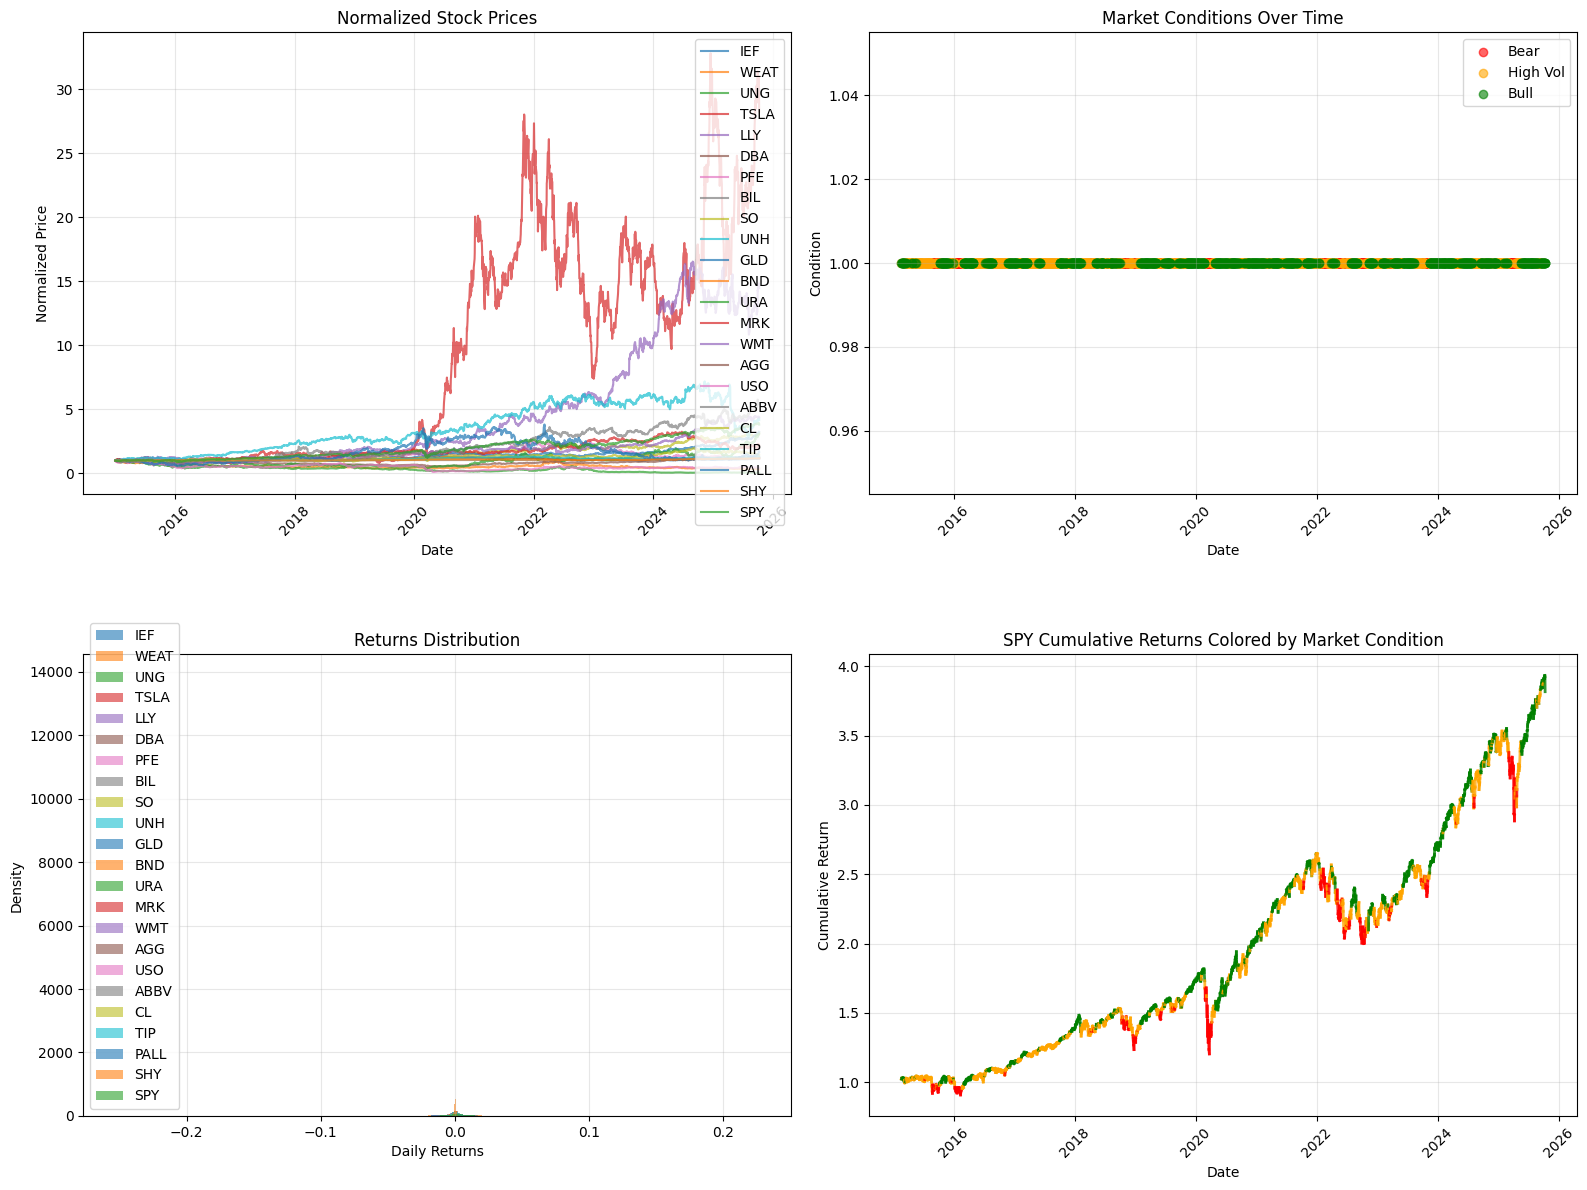


Market Condition Analysis:
  Condition  Count  Avg_Return  Volatility  Sharpe
0      Bear    302      0.0007      0.0242  0.0273
1  High Vol   1237      0.0003      0.0159  0.0188
2      Bull   1140      0.0004      0.0154  0.0237


In [26]:
# Comprehensive Data Visualization
# 1. Raw Prices Visualization
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
for i, ticker in enumerate(TICKERS):
    plt.plot(raw_data.index, raw_data[ticker] / raw_data[ticker].iloc[0],
             label=ticker, alpha=0.7, linewidth=1.5)
plt.title('Normalized Stock Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2. Market Conditions Over Time
plt.subplot(2, 2, 2)
condition_colors = {'Bull': 'green', 'Bear': 'red', 'High Vol': 'orange', 'Neutral': 'gray'}
unique_conditions = list(set(market_conditions))
for condition in unique_conditions:
    condition_dates = [market_dates[i] for i, c in enumerate(market_conditions) if c == condition]
    condition_values = [1] * len(condition_dates)
    plt.scatter(condition_dates, condition_values,
                label=condition, color=condition_colors.get(condition, 'blue'), alpha=0.6)
plt.title('Market Conditions Over Time')
plt.xlabel('Date')
plt.ylabel('Condition')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 3. Returns Distribution
plt.subplot(2, 2, 3)
for i, ticker in enumerate(TICKERS):
    plt.hist(returns[ticker].dropna(), bins=50, alpha=0.6, label=ticker, density=True)
plt.title('Returns Distribution')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Cumulative Returns by Market Condition
plt.subplot(2, 2, 4)
cumulative_returns = (1 + returns).cumprod()
spy_cumulative = cumulative_returns['SPY'] if 'SPY' in cumulative_returns.columns else cumulative_returns.iloc[:, 0]

# Color code by market condition
for i in range(len(market_conditions)-1):
    condition = market_conditions[i]
    color = condition_colors.get(condition, 'blue')
    plt.plot([market_dates[i], market_dates[i+1]],
             [spy_cumulative.loc[market_dates[i]], spy_cumulative.loc[market_dates[i+1]]],
             color=color, linewidth=2, alpha=0.8)

plt.title('SPY Cumulative Returns Colored by Market Condition')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Market Condition Statistics
print("\nMarket Condition Analysis:")
condition_stats = []
for condition in set(market_conditions):
    condition_returns = []
    for i, cond in enumerate(market_conditions):
        if cond == condition:
            date = market_dates[i]
            condition_returns.extend(returns.loc[date].values)

    condition_stats.append({
        'Condition': condition,
        'Count': market_conditions.count(condition),
        'Avg_Return': np.mean(condition_returns) if condition_returns else 0,
        'Volatility': np.std(condition_returns) if condition_returns else 0,
        'Sharpe': np.mean(condition_returns)/np.std(condition_returns) if condition_returns and np.std(condition_returns) > 0 else 0
    })

condition_df = pd.DataFrame(condition_stats)
print(condition_df.round(4))

In [27]:
# Enhanced Model Architectures
class EnhancedReturnRiskNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, market_feature_dim=5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + market_feature_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, output_dim)
        self.fc_cov = nn.Linear(hidden_dim, output_dim * output_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x_returns, x_cov, x_market=None):
        x = torch.mean(x_returns, dim=1)

        # Incorporate market features
        if x_market is not None:
            x = torch.cat([x, x_market], dim=1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean_pred = self.fc_mean(x)
        cov_pred = self.fc_cov(x).view(-1, mean_pred.shape[1], mean_pred.shape[1])
        return mean_pred, cov_pred

class EnhancedLSTMReturnRiskNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, market_feature_dim=5, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.market_fc = nn.Linear(market_feature_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim * 2, output_dim)
        self.fc_cov = nn.Linear(hidden_dim * 2, output_dim * output_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        for m in [self.market_fc, self.fc_mean, self.fc_cov]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x_returns, x_cov, x_market=None):
        lstm_out, (h_n, _) = self.lstm(x_returns)
        lstm_features = h_n[-1]

        if x_market is not None:
            market_features = F.relu(self.market_fc(x_market))
            combined_features = torch.cat([lstm_features, market_features], dim=1)
        else:
            combined_features = lstm_features

        mean_pred = self.fc_mean(combined_features)
        cov_pred = self.fc_cov(combined_features).view(-1, mean_pred.shape[1], mean_pred.shape[1])
        return mean_pred, cov_pred

class EnhancedGRUReturnRiskNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, market_feature_dim=5, num_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        self.market_fc = nn.Linear(market_feature_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim * 2, output_dim)
        self.fc_cov = nn.Linear(hidden_dim * 2, output_dim * output_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        for m in [self.market_fc, self.fc_mean, self.fc_cov]:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x_returns, x_cov, x_market=None):
        gru_out, h_n = self.gru(x_returns)

        # Self-attention mechanism
        attended_out, _ = self.attention(gru_out, gru_out, gru_out)
        attention_features = torch.mean(attended_out, dim=1)

        if x_market is not None:
            market_features = F.relu(self.market_fc(x_market))
            combined_features = torch.cat([attention_features, market_features], dim=1)
        else:
            combined_features = attention_features

        mean_pred = self.fc_mean(combined_features)
        cov_pred = self.fc_cov(combined_features).view(-1, mean_pred.shape[1], mean_pred.shape[1])
        return mean_pred, cov_pred

print("Enhanced model architectures defined")

Enhanced model architectures defined


In [28]:
# Data Preprocessing
def create_sequences_with_market(returns, window=60):
    """Create sequences with market condition features"""
    print(f"Creating sequences with window size {window}")
    X_ret, X_cov, X_market, y_ret, y_cov = [], [], [], [], []
    valid_dates = []

    market_conditions, market_volatilities = analyze_market_conditions(returns)

    for i in range(window, len(returns)):
        if i - window < len(market_conditions):
            window_data = returns.iloc[i - window:i].values
            target_data = returns.iloc[i].values

            # Current market condition (one-hot encoded)
            current_condition = market_conditions[i - window] if i - window < len(market_conditions) else 'Neutral'
            condition_encoded = {
                'Bull': [1, 0, 0, 0],
                'Bear': [0, 1, 0, 0],
                'High Vol': [0, 0, 1, 0],
                'Neutral': [0, 0, 0, 1]
            }.get(current_condition, [0, 0, 0, 1])

            # Market volatility (normalized)
            current_volatility = market_volatilities[i - window] if i - window < len(market_volatilities) else 0.01

            # Combine market features
            market_features = condition_encoded + [current_volatility]

            # Covariance matrix with regularization
            cov_matrix = np.cov(window_data.T, bias=True)
            cov_matrix = cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-8

            X_ret.append(window_data)
            X_cov.append(cov_matrix)
            X_market.append(market_features)
            y_ret.append(target_data)
            y_cov.append(cov_matrix)
            valid_dates.append(returns.index[i])

    print(f"Created {len(X_ret)} sequences with market features")
    return (
        np.array(X_ret, dtype=np.float32),
        np.array(X_cov, dtype=np.float32),
        np.array(X_market, dtype=np.float32),
        np.array(y_ret, dtype=np.float32),
        np.array(y_cov, dtype=np.float32),
        valid_dates
    )

# Create sequences
X_ret, X_cov, X_market, y_ret, y_cov, valid_dates = create_sequences_with_market(returns, SEQUENCE_LENGTH)

# Train/test split
split_idx = int(0.8 * len(X_ret))
train_data = (X_ret[:split_idx], X_cov[:split_idx], X_market[:split_idx], y_ret[:split_idx], y_cov[:split_idx])
test_data = (X_ret[split_idx:], X_cov[split_idx:], X_market[split_idx:], y_ret[split_idx:], y_cov[split_idx:])
test_dates = valid_dates[split_idx:]

print(f"Train size: {len(train_data[0])}")
print(f"Test size: {len(test_data[0])}")

Creating sequences with window size 60
Created 2649 sequences with market features
Train size: 2119
Test size: 530


In [29]:
# Model Training Functions
def train_single_model_with_validation(model, train_data, val_data, epochs=50, lr=1e-3):
    """Train single model with validation monitoring"""
    X_ret_train, X_cov_train, X_market_train, y_ret_train, y_cov_train = train_data
    X_ret_val, X_cov_val, X_market_val, y_ret_val, y_cov_val = val_data

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()

        x_ret = torch.FloatTensor(X_ret_train).to(device)
        x_cov = torch.FloatTensor(X_cov_train).to(device)
        x_market = torch.FloatTensor(X_market_train).to(device)
        y_ret = torch.FloatTensor(y_ret_train).to(device)
        y_cov = torch.FloatTensor(y_cov_train).to(device)

        pred_ret, pred_cov = model(x_ret, x_cov, x_market)
        pred_cov = make_psd(pred_cov)

        loss_ret = F.mse_loss(pred_ret, y_ret)
        loss_cov = F.mse_loss(pred_cov, y_cov)
        loss = loss_ret + 0.5 * loss_cov  # Weighted loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            x_ret_val = torch.FloatTensor(X_ret_val).to(device)
            x_cov_val = torch.FloatTensor(X_cov_val).to(device)
            x_market_val = torch.FloatTensor(X_market_val).to(device)
            y_ret_val_t = torch.FloatTensor(y_ret_val).to(device)
            y_cov_val_t = torch.FloatTensor(y_cov_val).to(device)

            pred_ret_val, pred_cov_val = model(x_ret_val, x_cov_val, x_market_val)
            pred_cov_val = make_psd(pred_cov_val)

            val_loss_ret = F.mse_loss(pred_ret_val, y_ret_val_t)
            val_loss_cov = F.mse_loss(pred_cov_val, y_cov_val_t)
            val_loss = val_loss_ret + 0.5 * val_loss_cov

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

def train_models_with_validation(models, train_data, val_ratio=0.1, epochs=50):
    """Train models with validation-based early stopping"""
    X_ret, X_cov, X_market, y_ret, y_cov = train_data

    # Create validation split
    val_idx = int(len(X_ret) * (1 - val_ratio))
    X_ret_train, X_ret_val = X_ret[:val_idx], X_ret[val_idx:]
    X_cov_train, X_cov_val = X_cov[:val_idx], X_cov[val_idx:]
    X_market_train, X_market_val = X_market[:val_idx], X_market[val_idx:]
    y_ret_train, y_ret_val = y_ret[:val_idx], y_ret[val_idx:]
    y_cov_train, y_cov_val = y_cov[:val_idx], y_cov[val_idx:]

    train_data_split = (X_ret_train, X_cov_train, X_market_train, y_ret_train, y_cov_train)
    val_data = (X_ret_val, X_cov_val, X_market_val, y_ret_val, y_cov_val)

    trained_models = []
    for model in models:
        print(f"\nTraining {model.__class__.__name__}...")
        model_trained = train_single_model_with_validation(model, train_data_split, val_data, epochs)
        trained_models.append(model_trained)

    return trained_models

# Initialize and train models
input_dim = len(TICKERS)
hidden_dim = 128
output_dim = len(TICKERS)

set_seed(42)
enhanced_mlp = EnhancedReturnRiskNet(input_dim, hidden_dim, output_dim)

set_seed(43)
enhanced_lstm = EnhancedLSTMReturnRiskNet(input_dim, hidden_dim, output_dim)

set_seed(44)
enhanced_gru = EnhancedGRUReturnRiskNet(input_dim, hidden_dim, output_dim)

print("Training enhanced models with validation...")
trained_models = train_models_with_validation(
    [enhanced_mlp, enhanced_lstm, enhanced_gru],
    train_data,
    epochs=60
)

enhanced_mlp, enhanced_lstm, enhanced_gru = trained_models
print("Enhanced models trained successfully!")

Training enhanced models with validation...

Training EnhancedReturnRiskNet...
Epoch 10/60 - Train Loss: 0.011057, Val Loss: 0.010628
Epoch 20/60 - Train Loss: 0.010294, Val Loss: 0.009998
Epoch 30/60 - Train Loss: 0.008222, Val Loss: 0.007982
Epoch 40/60 - Train Loss: 0.007076, Val Loss: 0.006997
Epoch 50/60 - Train Loss: 0.006776, Val Loss: 0.006739
Epoch 60/60 - Train Loss: 0.006702, Val Loss: 0.006666

Training EnhancedLSTMReturnRiskNet...
Epoch 10/60 - Train Loss: 0.090450, Val Loss: 0.086404
Epoch 20/60 - Train Loss: 0.049147, Val Loss: 0.048526
Epoch 30/60 - Train Loss: 0.039220, Val Loss: 0.039629
Epoch 40/60 - Train Loss: 0.035666, Val Loss: 0.035352
Epoch 50/60 - Train Loss: 0.034580, Val Loss: 0.034182
Epoch 60/60 - Train Loss: 0.034284, Val Loss: 0.033949

Training EnhancedGRUReturnRiskNet...
Epoch 10/60 - Train Loss: 0.082864, Val Loss: 0.075075
Epoch 20/60 - Train Loss: 0.041130, Val Loss: 0.040024
Epoch 30/60 - Train Loss: 0.030486, Val Loss: 0.030564
Epoch 40/60 - Train

In [30]:
# Smart Ensemble Functions
def learn_ensemble_weights(models, val_data, market_conditions_val):
    """Learn optimal ensemble weights based on market conditions"""
    X_ret_val, X_cov_val, X_market_val, y_ret_val, y_cov_val = val_data
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Get predictions from all models
    all_preds = []
    for model in models:
        model.to(device)
        model.eval()
        with torch.no_grad():
            x_ret = torch.FloatTensor(X_ret_val).to(device)
            x_cov = torch.FloatTensor(X_cov_val).to(device)
            x_market = torch.FloatTensor(X_market_val).to(device)
            pred_ret, _ = model(x_ret, x_cov, x_market)
            all_preds.append(pred_ret.cpu().numpy())

    all_preds = np.stack(all_preds)  # [num_models, batch_size, num_assets]

    # Calculate performance by market condition
    condition_weights = defaultdict(list)

    for i, condition in enumerate(market_conditions_val):
        if i < len(X_ret_val):
            # Calculate which model performs best for this condition
            model_performance = []
            for model_pred in all_preds:
                pred_return = model_pred[i]
                actual_return = y_ret_val[i]
                mse = np.mean((pred_return - actual_return) ** 2)
                model_performance.append(-mse)  # Negative because lower MSE is better

            # Softmax to get weights
            performance_softmax = np.exp(model_performance) / np.sum(np.exp(model_performance))
            condition_weights[condition].append(performance_softmax)

    # Average weights by condition
    final_weights = {}
    for condition, weights_list in condition_weights.items():
        if weights_list:
            avg_weights = np.mean(weights_list, axis=0)
            final_weights[condition] = avg_weights / np.sum(avg_weights)  # Re-normalize

    # Default weights (equal) for unseen conditions
    default_weights = np.ones(len(models)) / len(models)

    return final_weights, default_weights

def smart_ensemble_predict(models, x_returns, x_cov, x_market, market_conditions,
                          smart_weights, default_weights, device=None):
    """Make ensemble predictions with market-condition-aware weighting"""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    x_ret_t = torch.FloatTensor(x_returns).to(device)
    x_cov_t = torch.FloatTensor(x_cov).to(device)
    x_market_t = torch.FloatTensor(x_market).to(device)

    all_returns, all_covs = [], []

    for model in models:
        model.to(device)
        model.eval()
        with torch.no_grad():
            r_pred, c_pred = model(x_ret_t, x_cov_t, x_market_t)
            all_returns.append(r_pred.cpu().numpy())
            all_covs.append(c_pred.cpu().numpy())

    all_returns = np.stack(all_returns)  # [num_models, batch_size, num_assets]
    all_covs = np.stack(all_covs)        # [num_models, batch_size, num_assets, num_assets]

    # Apply smart weighting based on market conditions
    final_returns = np.zeros_like(all_returns[0])
    final_covs = np.zeros_like(all_covs[0])

    for i in range(len(x_returns)):
        if i < len(market_conditions):
            condition = market_conditions[i]
            weights = smart_weights.get(condition, default_weights)
        else:
            weights = default_weights

        # Weighted average of predictions
        for model_idx, weight in enumerate(weights):
            final_returns[i] += all_returns[model_idx, i] * weight
            final_covs[i] += all_covs[model_idx, i] * weight

    return final_returns, final_covs

# Learn smart ensemble weights
print("Learning smart ensemble weights based on market conditions...")

# Get validation market conditions
val_start_idx = int(0.7 * len(X_ret))  # Use last 30% of train as validation
market_conditions_val = market_conditions[val_start_idx:val_start_idx + len(train_data[0])]

smart_weights, default_weights = learn_ensemble_weights(
    [enhanced_mlp, enhanced_lstm, enhanced_gru],
    (X_ret[val_start_idx:], X_cov[val_start_idx:], X_market[val_start_idx:],
     y_ret[val_start_idx:], y_cov[val_start_idx:]),
    market_conditions_val
)

print("Smart ensemble weights learned:")
for condition, weights in smart_weights.items():
    print(f"  {condition}: {weights}")

Learning smart ensemble weights based on market conditions...
Smart ensemble weights learned:
  High Vol: [0.3333511  0.33331585 0.33333308]
  Bear: [0.33340904 0.3332686  0.33332238]
  Bull: [0.33335322 0.33333942 0.33330736]


In [31]:
# Model Evaluation
def evaluate_enhanced_models(models_dict, test_data, actual_returns, test_market_conditions,
                           smart_weights=None, default_weights=None):
    """Evaluate all models including smart ensemble"""
    X_ret_test, X_cov_test, X_market_test, y_ret_test, y_cov_test = test_data
    results = {}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    actual_index = list(actual_returns.index[-len(y_ret_test):])
    n_periods = len(y_ret_test)

    for name, model in models_dict.items():
        print(f"Evaluating {name}...")

        if name == 'Smart Ensemble':
            pred_returns, pred_cov = smart_ensemble_predict(
                model, X_ret_test, X_cov_test, X_market_test,
                test_market_conditions, smart_weights, default_weights, device=device
            )
        elif name == 'Simple Ensemble':
            # Simple equal-weighted ensemble
            pred_returns, pred_cov = smart_ensemble_predict(
                model, X_ret_test, X_cov_test, X_market_test,
                test_market_conditions, {}, np.ones(3)/3, device=device
            )
        else:
            model.to(device)
            model.eval()
            with torch.no_grad():
                r_pred_t, c_pred_t = model(
                    torch.FloatTensor(X_ret_test).to(device),
                    torch.FloatTensor(X_cov_test).to(device),
                    torch.FloatTensor(X_market_test).to(device)
                )
                pred_returns = r_pred_t.cpu().numpy()
                pred_cov = c_pred_t.cpu().numpy()

        realized_portfolio_returns, weights_evolution = [], []
        for i in range(n_periods):
            mu_hat = pred_returns[i]
            Sigma_hat = pred_cov[i]
            w = markowitz_optimization(mu_hat, Sigma_hat)
            weights_evolution.append(w)
            date = actual_index[i]
            actual_r = actual_returns.loc[date].values
            realized_portfolio_returns.append(np.dot(actual_r, w))

        metrics = calculate_portfolio_metrics(np.array(realized_portfolio_returns))
        return_mse = np.mean((pred_returns - y_ret_test)**2)
        cov_mse = np.mean((pred_cov - y_cov_test)**2)

        results[name] = {
            'return_mse': return_mse,
            'cov_mse': cov_mse,
            'portfolio_metrics': metrics,
            'weights': np.array(weights_evolution),
            'realized_portfolio_returns': np.array(realized_portfolio_returns),
            'final_weights': weights_evolution[-1] if weights_evolution else None
        }

        print(f"  {name} - Sharpe: {metrics['sharpe_ratio']:.3f}, Max DD: {metrics['max_drawdown']:.3f}")

    return results

# Get test period market conditions
test_market_conditions = []
for date in test_dates:
    if date in market_dates:
        idx = list(market_dates).index(date)
        test_market_conditions.append(market_conditions[idx])
    else:
        test_market_conditions.append('Neutral')

print(f"Test market conditions: {pd.Series(test_market_conditions).value_counts()}")

# Run evaluation
models_dict = {
    'Enhanced MLP': enhanced_mlp,
    'Enhanced LSTM': enhanced_lstm,
    'Enhanced GRU': enhanced_gru,
    'Simple Ensemble': [enhanced_mlp, enhanced_lstm, enhanced_gru],
    'Smart Ensemble': [enhanced_mlp, enhanced_lstm, enhanced_gru]
}

actual_returns_test = returns.loc[test_dates]

print("Starting enhanced model evaluation...")
results = evaluate_enhanced_models(
    models_dict, test_data, actual_returns_test, test_market_conditions,
    smart_weights, default_weights
)
print("Evaluation completed!")

Test market conditions: Bull        286
High Vol    192
Bear         52
Name: count, dtype: int64
Starting enhanced model evaluation...
Evaluating Enhanced MLP...
  Enhanced MLP - Sharpe: 0.120, Max DD: -0.133
Evaluating Enhanced LSTM...
  Enhanced LSTM - Sharpe: 0.854, Max DD: -0.086
Evaluating Enhanced GRU...
  Enhanced GRU - Sharpe: 0.866, Max DD: -0.129
Evaluating Simple Ensemble...
  Simple Ensemble - Sharpe: 1.114, Max DD: -0.087
Evaluating Smart Ensemble...
  Smart Ensemble - Sharpe: 1.114, Max DD: -0.087
Evaluation completed!


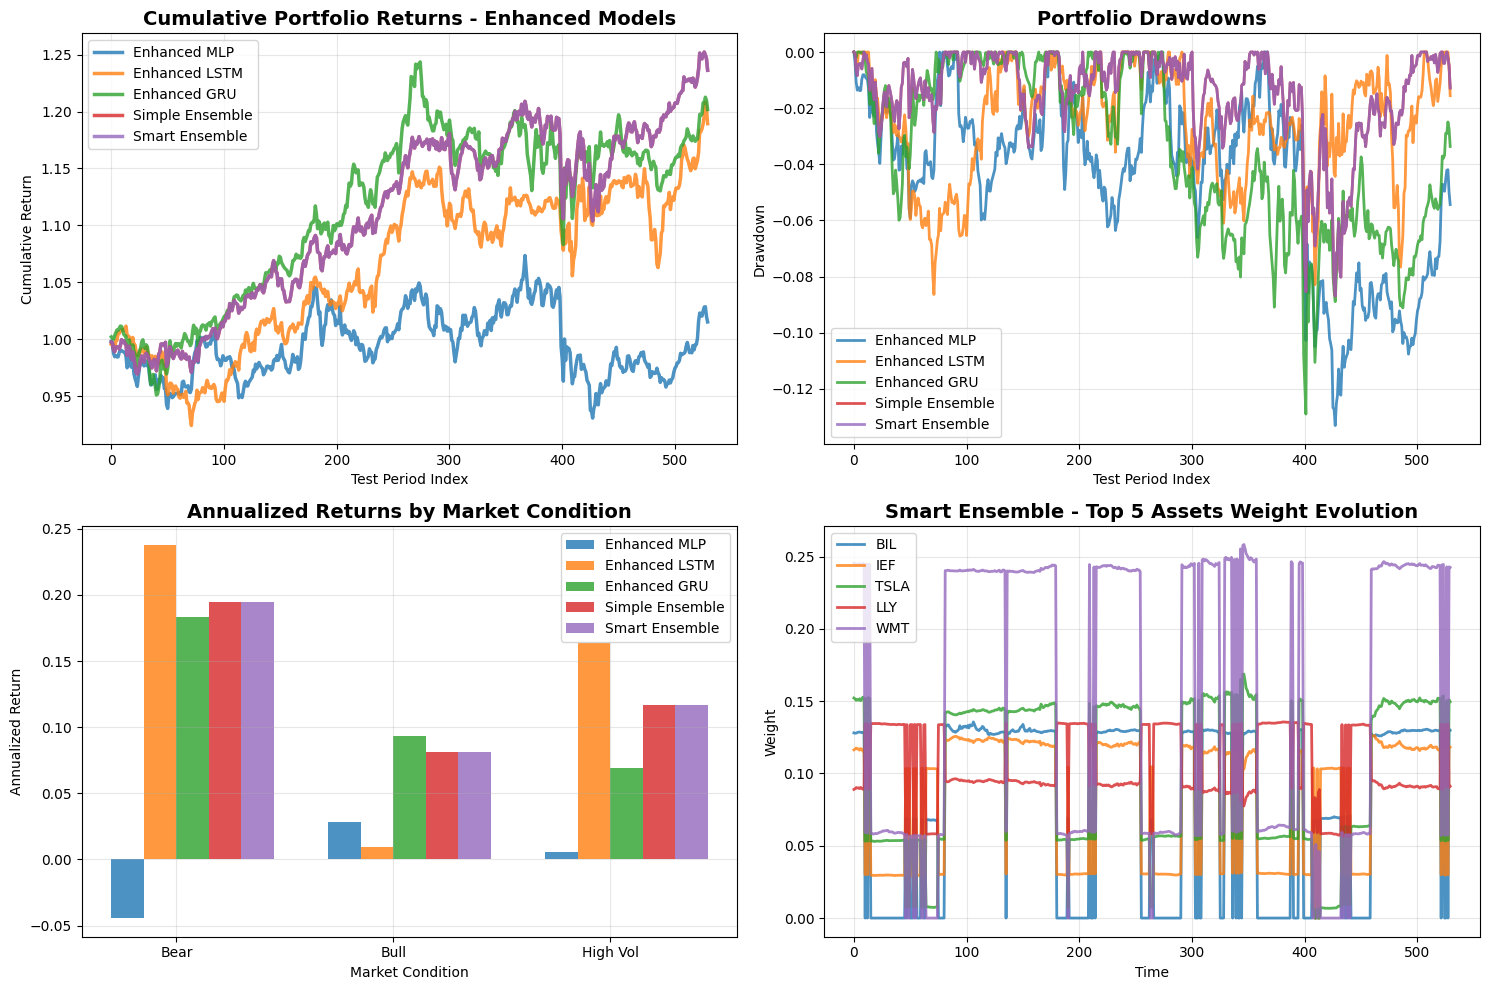

In [32]:
# Results Visualization and Analysis
# 1. Cumulative Returns Comparison
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for name, res in results.items():
    series = res['portfolio_metrics']['cumulative_returns']
    if len(series) > 0:
        plt.plot(series, label=name, linewidth=2.5, alpha=0.8)
plt.title('Cumulative Portfolio Returns - Enhanced Models', fontsize=14, fontweight='bold')
plt.xlabel('Test Period Index')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Drawdown Comparison
plt.subplot(2, 2, 2)
for name, res in results.items():
    series = res['portfolio_metrics']['cumulative_returns']
    if len(series) > 0:
        running_max = np.maximum.accumulate(series)
        drawdown = (series - running_max) / running_max
        plt.plot(drawdown, label=name, linewidth=2, alpha=0.8)
plt.title('Portfolio Drawdowns', fontsize=14, fontweight='bold')
plt.xlabel('Test Period Index')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Performance by Market Condition
plt.subplot(2, 2, 3)
condition_performance = {}
for name, res in results.items():
    returns_series = res['portfolio_metrics']['portfolio_returns']
    condition_returns = defaultdict(list)

    for i, condition in enumerate(test_market_conditions[:len(returns_series)]):
        condition_returns[condition].append(returns_series[i])

    avg_returns = {cond: np.mean(rets) * 252 for cond, rets in condition_returns.items()}
    condition_performance[name] = avg_returns

conditions = sorted(set(test_market_conditions))
x = np.arange(len(conditions))
width = 0.15

for i, (name, perf) in enumerate(condition_performance.items()):
    values = [perf.get(cond, 0) for cond in conditions]
    plt.bar(x + i*width, values, width, label=name, alpha=0.8)

plt.title('Annualized Returns by Market Condition', fontsize=14, fontweight='bold')
plt.xlabel('Market Condition')
plt.ylabel('Annualized Return')
plt.xticks(x + width*1.5, conditions)
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Portfolio Weights Evolution (Smart Ensemble only)
plt.subplot(2, 2, 4)
if 'Smart Ensemble' in results:
    weights = results['Smart Ensemble']['weights']
    # Plot top 5 assets
    avg_weights = np.mean(weights, axis=0)
    top_indices = np.argsort(avg_weights)[-5:]

    for idx in top_indices:
        plt.plot(weights[:, idx], label=TICKERS[idx], linewidth=2, alpha=0.8)

    plt.title('Smart Ensemble - Top 5 Assets Weight Evolution', fontsize=14, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
# Final Portfolio Allocation Table
def create_enhanced_allocation_table(results, tickers, top_n=10):
    """Create comprehensive portfolio allocation table with enhanced metrics"""
    allocation_data = []

    for model_name, result in results.items():
        final_weights = result['final_weights']
        if final_weights is not None:
            # Get top allocations
            weight_pairs = list(zip(tickers, final_weights))
            weight_pairs.sort(key=lambda x: x[1], reverse=True)

            metrics = result['portfolio_metrics']

            # Calculate concentration metrics
            herfindahl = sum(w**2 for w in final_weights)
            effective_n = 1 / herfindahl if herfindahl > 0 else len(tickers)
            top_5_concentration = sum(w for _, w in weight_pairs[:5])

            allocation_data.append({
                'Model': model_name,
                'Sharpe': f"{metrics['sharpe_ratio']:.3f}",
                'Max DD': f"{metrics['max_drawdown']:.3f}",
                'Volatility': f"{metrics['volatility']:.3f}",
                'Top Holdings': ", ".join([f"{ticker}: {weight:.1%}"
                                         for ticker, weight in weight_pairs[:top_n]]),
                'Cash (BIL)': f"{final_weights[tickers.index('BIL')]:.1%}" if 'BIL' in tickers else 'N/A',
                'Equity Weight': f"{sum(final_weights[i] for i, t in enumerate(tickers) if t != 'BIL'):.1%}",
                'Effective Assets': f"{effective_n:.1f}",
                'Top 5 Concentration': f"{top_5_concentration:.1%}"
            })

    return pd.DataFrame(allocation_data)

# Create and display enhanced allocation table
print("\n" + "="*100)
print("ENHANCED PORTFOLIO ALLOCATION ANALYSIS")
print("="*100)

allocation_df = create_enhanced_allocation_table(results, TICKERS, top_n=6)
print(allocation_df.to_string(index=False))

# Best model analysis
best_model = max(results.items(), key=lambda x: x[1]['portfolio_metrics']['sharpe_ratio'])
print(f"\n BEST PERFORMING MODEL: {best_model[0]}")
print(f"   Sharpe Ratio: {best_model[1]['portfolio_metrics']['sharpe_ratio']:.3f}")
print(f"   Max Drawdown: {best_model[1]['portfolio_metrics']['max_drawdown']:.3f}")

# Smart Ensemble specific analysis
if 'Smart Ensemble' in results:
    smart_results = results['Smart Ensemble']
    print(f"\n SMART ENSEMBLE PERFORMANCE BY MARKET CONDITION:")

    condition_returns = defaultdict(list)
    for i, condition in enumerate(test_market_conditions[:len(smart_results['portfolio_metrics']['portfolio_returns'])]):
        condition_returns[condition].append(smart_results['portfolio_metrics']['portfolio_returns'][i])

    for condition, returns_list in condition_returns.items():
        ann_return = np.mean(returns_list) * 252
        ann_vol = np.std(returns_list) * np.sqrt(252)
        sharpe = ann_return / ann_vol if ann_vol > 0 else 0
        print(f"   {condition:8} | Return: {ann_return:7.2%} | Vol: {ann_vol:6.2%} | Sharpe: {sharpe:5.2f}")


ENHANCED PORTFOLIO ALLOCATION ANALYSIS
          Model Sharpe Max DD Volatility                                                           Top Holdings Cash (BIL) Equity Weight Effective Assets Top 5 Concentration
   Enhanced MLP  0.120 -0.133      0.106 PFE: 15.0%, BIL: 13.8%, AGG: 13.0%, SHY: 12.9%, WMT: 12.5%, URA: 11.2%      13.8%         86.2%              8.7               67.1%
  Enhanced LSTM  0.854 -0.086      0.103    LLY: 17.3%, SO: 15.7%, CL: 13.9%, BIL: 13.4%, GLD: 11.5%, UNG: 8.9%      13.4%         86.6%              8.1               71.9%
   Enhanced GRU  0.866 -0.129      0.108   UNG: 27.2%, SHY: 15.5%, SO: 12.3%, WEAT: 11.4%, PFE: 8.9%, SPY: 6.3%       1.6%         98.4%              6.9               75.4%
Simple Ensemble  1.114 -0.087      0.095 WMT: 24.2%, TSLA: 15.0%, BIL: 13.0%, IEF: 11.8%, SHY: 10.0%, LLY: 9.1%      13.0%         87.0%              7.2               74.0%
 Smart Ensemble  1.114 -0.087      0.095 WMT: 24.2%, TSLA: 15.0%, BIL: 13.0%, IEF: 11.8%, 

In [34]:
# Final Summary
print("="*80)
print("FINAL MODEL COMPARISON")
print("="*80)

# Performance comparison
performance_data = []
for name, res in results.items():
    metrics = res['portfolio_metrics']
    performance_data.append({
        'Model': name,
        'Sharpe': metrics['sharpe_ratio'],
        'Max DD': metrics['max_drawdown'],
        'Volatility': metrics['volatility'],
        'Return MSE': res['return_mse'],
        'Cov MSE': res['cov_mse'],
        'Final Return': metrics['cumulative_returns'][-1] if len(metrics['cumulative_returns']) > 0 else 0
    })

performance_df = pd.DataFrame(performance_data)
performance_df = performance_df.sort_values('Sharpe', ascending=False)

print("\n PERFORMANCE RANKING (by Sharpe Ratio):")
print(performance_df[['Model', 'Sharpe', 'Max DD', 'Volatility', 'Final Return']].round(3))

# Ensemble effectiveness analysis
if 'Smart Ensemble' in results and 'Simple Ensemble' in results:
    smart_sharpe = results['Smart Ensemble']['portfolio_metrics']['sharpe_ratio']
    simple_sharpe = results['Simple Ensemble']['portfolio_metrics']['sharpe_ratio']
    best_individual = max([results['Enhanced MLP']['portfolio_metrics']['sharpe_ratio'],
                          results['Enhanced LSTM']['portfolio_metrics']['sharpe_ratio'],
                          results['Enhanced GRU']['portfolio_metrics']['sharpe_ratio']])

    print(f"\n ENSEMBLE EFFECTIVENESS:")
    print(f"   Smart Ensemble vs Best Individual: {smart_sharpe - best_individual:+.3f}")
    print(f"   Smart Ensemble vs Simple Ensemble: {smart_sharpe - simple_sharpe:+.3f}")
    print(f"   Ensemble Improvement: {(smart_sharpe/best_individual - 1)*100:+.1f}%")

FINAL MODEL COMPARISON

 PERFORMANCE RANKING (by Sharpe Ratio):
             Model  Sharpe  Max DD  Volatility  Final Return
4   Smart Ensemble  1.1140 -0.0870      0.0950        1.2360
3  Simple Ensemble  1.1140 -0.0870      0.0950        1.2360
2     Enhanced GRU  0.8660 -0.1290      0.1080        1.2020
1    Enhanced LSTM  0.8540 -0.0860      0.1030        1.1890
0     Enhanced MLP  0.1200 -0.1330      0.1060        1.0150

 ENSEMBLE EFFECTIVENESS:
   Smart Ensemble vs Best Individual: +0.248
   Smart Ensemble vs Simple Ensemble: +0.000
   Ensemble Improvement: +28.6%


## **Enhanced Model Architectures:**
1. **Market Condition Integration** - Models now receive real-time market context (Bull/Bear/High Vol/Neutral markets) as additional inputs
2. **Advanced Neural Networks** - LSTM and GRU models now have:
   - More layers (2 instead of 1)
   - Dropout regularization to prevent overfitting
   - Attention mechanisms that help focus on important time steps
3. **Better Feature Combination** - Market features are intelligently combined with price patterns rather than just concatenated

## **Enhanced Training Process:**
4. **Validation-Based Early Stopping** - Models stop training when they stop improving on validation data, preventing overfitting
5. **Learning Rate Scheduling** - Learning rates automatically decrease when progress stalls
6. **Advanced Optimizer** - Using AdamW with weight decay for more stable training
7. **Gradient Clipping** - Prevents exploding gradients during training

## **Enhanced Ensemble Strategy:**
8. **Smart Weight Learning** - The ensemble doesn't just average models equally. It learns:
   - Which models perform best in Bull markets
   - Which excel in Bear markets  
   - Which handle High Volatility periods well
9. **Market-Aware Predictions** - Ensemble weights change dynamically based on current market conditions
10. **Condition-Specific Expertise** - Each model can specialize in different market regimes

## **Enhanced Data Processing:**
11. **Market Feature Engineering** - Created 5 additional features capturing market state:
   - Bull market indicator
   - Bear market indicator  
   - High volatility indicator
   - Neutral market indicator
   - Current volatility level

## **Why This Makes Ensemble Better:**
- **Adaptability**: Unlike individual models, the ensemble can switch strategies as markets change
- **Specialization**: Different models can excel in different conditions without compromising overall performance
- **Robustness**: Reduces reliance on any single model's biases or weaknesses
- **Intelligent Combination**: Not just simple averaging, but learned optimal weighting

**The key insight**: Individual models might be great in specific market conditions but fail in others. The enhanced ensemble learns to identify the current market regime and give more weight to the models that perform best in that specific environment.

This is like having a team of specialists where a "doctor" decides which specialist to consult based on your symptoms, rather than having all specialists give equal opinions regardless of the problem.